In [1]:
from matplotlib import pyplot as plt
import jax.numpy as jnp
from jax import random

from simplecryoem.emfiles import load_data
from simplecryoem.preprocess import preprocess
from simplecryoem.forwardmodel import Slice
from simplecryoem.optimization import Loss, GradV, sgd, get_sgd_vol_ops, precon_sgd
from simplecryoem.utils import mip_x

In [2]:
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 6, 6

In [3]:
#data_dir = "../../../RELION_TUTORIAL_SET/"
#star_file = "particles.star"

data_dir = "/gpfs/gibbs/pi/lederman/dge5/RELION_TUTORIAL_SET/PrecalculatedResults/"
star_file = "/Extract/job018/particles.star"

In [4]:
params0, imgs0 = load_data(data_dir, star_file, load_imgs=True, fourier=False)

print(f"params0 keys: {params0.keys()}")
print(f"imgs0.shape = {imgs0.shape}")

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles: 4501
load_data: data loaded, time:  2.68 sec.
params0 keys: dict_keys(['ctf_params', 'pixel_size', 'angles', 'shifts'])
imgs0.shape = (4501, 256, 256)


In [5]:
processed_data = preprocess(imgs0, params0)

imgs0.shape = (4501, 256, 256)
pixel_size0.shape = (4501,)
angles0.shape = (4501, 3)
shifts0.shape = (4501, 2)
ctf_params0.shape = (4501, 9)
N0 = 4501
idx not provided
N = 4501
Taking FFT of the images:
Batch 1/10  0.89 sec.
Batch 2/10  0.89 sec.
Batch 3/10  0.89 sec.
Batch 4/10  0.89 sec.
Batch 5/10  0.89 sec.
Batch 6/10  0.89 sec.
Batch 7/10  0.89 sec.
Batch 8/10  0.89 sec.
Batch 9/10  0.89 sec.
Batch 10/10  0.89 sec.
FFT done. Time:  10.57 sec.
x_grid = [3.13873258e-03 2.56000000e+02]
Vectorised imgs_f.shape = (4501, 65536)
Mask radius = 0.39861903801512377
Noise free, setting sigma_noise = 1


In [6]:
key = random.PRNGKey(20)

In [7]:
N = 4000

key, subkey = random.split(key)
idx_shuffle = random.permutation(subkey, N)

In [8]:
# Images and image-specific parameters
# (orientation angles, in-plane shifts, ctf parameters)

imgs_f = processed_data["imgs_f"][idx_shuffle]
angles = processed_data["angles"][idx_shuffle]
shifts = processed_data["shifts"][idx_shuffle]
ctf_params = processed_data["ctf_params"][idx_shuffle]

# These parameters are the same for all images
pixel_size = processed_data["pixel_size"]
nx = processed_data["nx"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
x_grid = processed_data["x_grid"]
N = imgs_f.shape[0]

In [9]:
# Use the x=0 slice of the 3D mask output by the preprocess function
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

In [10]:
# Regularization parameter
alpha = 1e-8

slice_obj_tri = Slice(x_grid, mask=mask, interp_method="tri")
loss_obj_tri = Loss(slice_obj_tri, alpha=alpha)
gradv_obj_tri = GradV(loss_obj_tri)

slice_obj_nn = Slice(x_grid, mask=mask, interp_method="nn")
loss_obj_nn = Loss(slice_obj_nn, alpha=alpha)
gradv_obj_nn = GradV(loss_obj_nn)

In [11]:
grad_func_tri1, loss_func_tri1, hvp_func_tri1, _ = get_sgd_vol_ops(
    gradv_obj_tri, loss_obj_tri, angles[:N//2], shifts[:N//2], ctf_params[:N//2], imgs_f[:N//2], sigma_noise
)

grad_func_tri2, loss_func_tri2, hvp_func_tri2, _ = get_sgd_vol_ops(
    gradv_obj_tri, loss_obj_tri, angles[N//2:], shifts[N//2:], ctf_params[N//2:], imgs_f[N//2:], sigma_noise
)

In [12]:
grad_func_nn1, loss_func_nn1, hvp_func_nn1, _ = get_sgd_vol_ops(
    gradv_obj_nn, loss_obj_nn, angles[:N//2], shifts[:N//2], ctf_params[:N//2], imgs_f[:N//2], sigma_noise
)

grad_func_nn2, loss_func_nn2, hvp_func_nn2, _ = get_sgd_vol_ops(
    gradv_obj_nn, loss_obj_nn, angles[N//2:], shifts[N//2:], ctf_params[N//2:], imgs_f[N//2:], sigma_noise
)

### SGD

In [13]:
# Initialization
v0 = jnp.zeros((nx, nx, nx))
D0 = jnp.ones(v0.shape)

N_epochs = 100
batch_size = 200
step_size = 1
c = 0.9

# Parameters specific to preconditioned SGD,
# see the documentation of precon_sgd for details.
beta = 0.5
thresh = 1e-6

In [14]:
N_epochs = 100


In [15]:
key, key_alg = random.split(key)

v_sgdp_tri1, loss_sgdp_tri1, _, _ = precon_sgd(
    key_alg,
    loss_func_tri1,
    grad_func_tri1,
    hvp_func_tri1,
    v0,
    step_size,
    D0,
    beta,
    thresh,
    N_epochs,
    batch_size,
    N//2,
    c=c,
    adaptive_step_size=True,
    iter_display=1,
)

Epoch 1/100


100%|██████████| 10/10 [00:27<00:00,  2.76s/it, eta=9.675e-02, loss=1.711e+09]


  Loss =  1.73864329e+09
  eta = 0.09674588159999999
  alpha= 1e-06
Epoch 2/100


100%|██████████| 10/10 [00:11<00:00,  1.18s/it, eta=1.512e-03, loss=1.741e+09]


  Loss =  1.73604750e+09
  eta = 0.0015116543999999998
  alpha= 1e-06
Epoch 3/100


100%|██████████| 10/10 [00:11<00:00,  1.16s/it, eta=3.023e-03, loss=1.733e+09]


  Loss =  1.73386397e+09
  eta = 0.0030233087999999996
  alpha= 1e-06
Epoch 4/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.729e+09]


  Loss =  1.73081013e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 5/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.729e+09]


  Loss =  1.72753403e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 6/100


100%|██████████| 10/10 [00:11<00:00,  1.16s/it, eta=3.023e-03, loss=1.726e+09]


  Loss =  1.72636796e+09
  eta = 0.0030233087999999996
  alpha= 1e-06
Epoch 7/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.723e+09]


  Loss =  1.72377300e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 8/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.723e+09]


  Loss =  1.72084921e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 9/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.715e+09]


  Loss =  1.71832607e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 10/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.711e+09]


  Loss =  1.71585991e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 11/100


100%|██████████| 10/10 [00:11<00:00,  1.16s/it, eta=3.023e-03, loss=1.726e+09]


  Loss =  1.71405470e+09
  eta = 0.0030233087999999996
  alpha= 1e-06
Epoch 12/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.719e+09]


  Loss =  1.71232431e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 13/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.708e+09]


  Loss =  1.71101857e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 14/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.710e+09]


  Loss =  1.70980006e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 15/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.707e+09]


  Loss =  1.70830670e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 16/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=2.419e-02, loss=1.693e+09]


  Loss =  1.70735891e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 17/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.700e+09]


  Loss =  1.70669124e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 18/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.695e+09]


  Loss =  1.70550305e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 19/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.697e+09]


  Loss =  1.70446365e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 20/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.704e+09]


  Loss =  1.70423784e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 21/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.714e+09]


  Loss =  1.70361683e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 22/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.707e+09]


  Loss =  1.70270057e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 23/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.705e+09]


  Loss =  1.70258788e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 24/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.703e+09]


  Loss =  1.70179030e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 25/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.706e+09]


  Loss =  1.70106441e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 26/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.705e+09]


  Loss =  1.70057357e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 27/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.693e+09]


  Loss =  1.70006854e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 28/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.691e+09]


  Loss =  1.69967441e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 29/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.690e+09]


  Loss =  1.69905978e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 30/100


100%|██████████| 10/10 [00:11<00:00,  1.10s/it, eta=2.419e-02, loss=1.690e+09]


  Loss =  1.69879392e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 31/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.699e+09]


  Loss =  1.69831343e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 32/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.699e+09]


  Loss =  1.69821838e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 33/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.713e+09]


  Loss =  1.69813433e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 34/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.683e+09]


  Loss =  1.69772036e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 35/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.689e+09]


  Loss =  1.69750338e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 36/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.703e+09]


  Loss =  1.69774692e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 37/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.693e+09]


  Loss =  1.69726870e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 38/100


100%|██████████| 10/10 [00:11<00:00,  1.16s/it, eta=3.023e-03, loss=1.708e+09]


  Loss =  1.69768596e+09
  eta = 0.0030233087999999996
  alpha= 1e-06
Epoch 39/100


100%|██████████| 10/10 [00:11<00:00,  1.15s/it, eta=6.047e-03, loss=1.708e+09]


  Loss =  1.69728149e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 40/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.697e+09]


  Loss =  1.69674703e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 41/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.697e+09]


  Loss =  1.69681548e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 42/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.694e+09]


  Loss =  1.69682760e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 43/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.701e+09]


  Loss =  1.69661659e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 44/100


100%|██████████| 10/10 [00:11<00:00,  1.16s/it, eta=3.023e-03, loss=1.716e+09]


  Loss =  1.69704561e+09
  eta = 0.0030233087999999996
  alpha= 1e-06
Epoch 45/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.696e+09]


  Loss =  1.69695696e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 46/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.702e+09]


  Loss =  1.69634980e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 47/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.691e+09]


  Loss =  1.69615132e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 48/100


100%|██████████| 10/10 [00:11<00:00,  1.10s/it, eta=2.419e-02, loss=1.687e+09]


  Loss =  1.69591868e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 49/100


100%|██████████| 10/10 [00:11<00:00,  1.16s/it, eta=3.023e-03, loss=1.713e+09]


  Loss =  1.69688698e+09
  eta = 0.0030233087999999996
  alpha= 1e-06
Epoch 50/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.707e+09]


  Loss =  1.69664688e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 51/100


100%|██████████| 10/10 [00:11<00:00,  1.15s/it, eta=6.047e-03, loss=1.701e+09]


  Loss =  1.69670123e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 52/100


100%|██████████| 10/10 [00:11<00:00,  1.10s/it, eta=2.419e-02, loss=1.694e+09]


  Loss =  1.69579798e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 53/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.686e+09]


  Loss =  1.69559944e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 54/100


100%|██████████| 10/10 [00:10<00:00,  1.08s/it, eta=4.837e-02, loss=1.674e+09]


  Loss =  1.69642874e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 55/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.699e+09]


  Loss =  1.69624044e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 56/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.707e+09]


  Loss =  1.69603506e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 57/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.705e+09]


  Loss =  1.69568379e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 58/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.695e+09]


  Loss =  1.69535441e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 59/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.686e+09]


  Loss =  1.69532793e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 60/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.693e+09]


  Loss =  1.69537494e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 61/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.701e+09]


  Loss =  1.69594222e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 62/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.706e+09]


  Loss =  1.69531350e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 63/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.697e+09]


  Loss =  1.69493159e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 64/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.699e+09]


  Loss =  1.69491833e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 65/100


100%|██████████| 10/10 [00:10<00:00,  1.08s/it, eta=4.837e-02, loss=1.668e+09]


  Loss =  1.69575732e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 66/100


100%|██████████| 10/10 [00:11<00:00,  1.10s/it, eta=2.419e-02, loss=1.695e+09]


  Loss =  1.69547521e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 67/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.694e+09]


  Loss =  1.69503164e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 68/100


100%|██████████| 10/10 [00:11<00:00,  1.15s/it, eta=6.047e-03, loss=1.715e+09]


  Loss =  1.69510899e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 69/100


100%|██████████| 10/10 [00:10<00:00,  1.08s/it, eta=4.837e-02, loss=1.671e+09]


  Loss =  1.69591575e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 70/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.689e+09]


  Loss =  1.69576487e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 71/100


100%|██████████| 10/10 [00:11<00:00,  1.10s/it, eta=2.419e-02, loss=1.696e+09]


  Loss =  1.69491167e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 72/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.687e+09]


  Loss =  1.69464956e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 73/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.699e+09]


  Loss =  1.69452173e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 74/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.689e+09]


  Loss =  1.69443218e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 75/100


100%|██████████| 10/10 [00:10<00:00,  1.08s/it, eta=4.837e-02, loss=1.671e+09]


  Loss =  1.69538884e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 76/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.686e+09]


  Loss =  1.69474110e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 77/100


100%|██████████| 10/10 [00:11<00:00,  1.10s/it, eta=2.419e-02, loss=1.686e+09]


  Loss =  1.69457263e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 78/100


100%|██████████| 10/10 [00:10<00:00,  1.08s/it, eta=4.837e-02, loss=1.660e+09]


  Loss =  1.69592777e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 79/100


100%|██████████| 10/10 [00:11<00:00,  1.10s/it, eta=2.419e-02, loss=1.687e+09]


  Loss =  1.69557445e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 80/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.691e+09]


  Loss =  1.69542498e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 81/100


100%|██████████| 10/10 [00:10<00:00,  1.08s/it, eta=4.837e-02, loss=1.673e+09]


  Loss =  1.69513797e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 82/100


 80%|████████  | 8/10 [00:10<00:02,  1.26s/it, eta=1.680e-02, loss=1.690e+09]


In [16]:
key, key_alg = random.split(key)

v_sgdp_tri2, loss_sgdp_tri2, _, _ = precon_sgd(
    key_alg,
    loss_func_tri2,
    grad_func_tri2,
    hvp_func_tri2,
    v0,
    step_size,
    D0,
    beta,
    thresh,
    N_epochs,
    batch_size,
    N//2,
    c=c,
    adaptive_step_size=True,
    iter_display=1,
)

Epoch 1/100


100%|██████████| 10/10 [00:13<00:00,  1.39s/it, eta=4.837e-02, loss=1.745e+09]


  Loss =  1.74030049e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 2/100


100%|██████████| 10/10 [00:11<00:00,  1.18s/it, eta=1.512e-03, loss=1.738e+09]


  Loss =  1.73644299e+09
  eta = 0.0015116543999999998
  alpha= 1e-06
Epoch 3/100


100%|██████████| 10/10 [00:11<00:00,  1.17s/it, eta=3.023e-03, loss=1.736e+09]


  Loss =  1.73389168e+09
  eta = 0.0030233087999999996
  alpha= 1e-06
Epoch 4/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.731e+09]


  Loss =  1.73094468e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 5/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.729e+09]


  Loss =  1.72757342e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 6/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.722e+09]


  Loss =  1.72452539e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 7/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.715e+09]


  Loss =  1.72131133e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 8/100


100%|██████████| 10/10 [00:11<00:00,  1.13s/it, eta=6.047e-03, loss=1.718e+09]


  Loss =  1.71864774e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 9/100


100%|██████████| 10/10 [00:11<00:00,  1.16s/it, eta=3.023e-03, loss=1.718e+09]


  Loss =  1.71721777e+09
  eta = 0.0030233087999999996
  alpha= 1e-06
Epoch 10/100


100%|██████████| 10/10 [00:11<00:00,  1.16s/it, eta=3.023e-03, loss=1.720e+09]


  Loss =  1.71555381e+09
  eta = 0.0030233087999999996
  alpha= 1e-06
Epoch 11/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.715e+09]


  Loss =  1.71335958e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 12/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.709e+09]


  Loss =  1.71167400e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 13/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.709e+09]


  Loss =  1.71025721e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 14/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.704e+09]


  Loss =  1.70895542e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 15/100


100%|██████████| 10/10 [00:11<00:00,  1.11s/it, eta=1.209e-02, loss=1.707e+09]


  Loss =  1.70769482e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 16/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.702e+09]


  Loss =  1.70645198e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 17/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.703e+09]


  Loss =  1.70536015e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 18/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.700e+09]


  Loss =  1.70443710e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 19/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.706e+09]


  Loss =  1.70411167e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 20/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.700e+09]


  Loss =  1.70323597e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 21/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.690e+09]


  Loss =  1.70301218e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 22/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.710e+09]


  Loss =  1.70214309e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 23/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.694e+09]


  Loss =  1.70169717e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 24/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.698e+09]


  Loss =  1.70094762e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 25/100


100%|██████████| 10/10 [00:11<00:00,  1.13s/it, eta=1.209e-02, loss=1.697e+09]


  Loss =  1.70016125e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 26/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.711e+09]


  Loss =  1.69983519e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 27/100


100%|██████████| 10/10 [00:11<00:00,  1.11s/it, eta=1.209e-02, loss=1.701e+09]


  Loss =  1.69936698e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 28/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.694e+09]


  Loss =  1.69926125e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 29/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.689e+09]


  Loss =  1.69915288e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 30/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.696e+09]


  Loss =  1.69858689e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 31/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.691e+09]


  Loss =  1.69824349e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 32/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.701e+09]


  Loss =  1.69812600e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 33/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.698e+09]


  Loss =  1.69776482e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 34/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.709e+09]


  Loss =  1.69844116e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 35/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.693e+09]


  Loss =  1.69768638e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 36/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.702e+09]


  Loss =  1.69759002e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 37/100


100%|██████████| 10/10 [00:10<00:00,  1.09s/it, eta=2.419e-02, loss=1.688e+09]


  Loss =  1.69699828e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 38/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.694e+09]


  Loss =  1.69726204e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 39/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.697e+09]


  Loss =  1.69660485e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 40/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.695e+09]


  Loss =  1.69630897e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 41/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.682e+09]


  Loss =  1.69613212e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 42/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.699e+09]


  Loss =  1.69617782e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 43/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.701e+09]


  Loss =  1.69601002e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 44/100


100%|██████████| 10/10 [00:10<00:00,  1.09s/it, eta=2.419e-02, loss=1.693e+09]


  Loss =  1.69587320e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 45/100


100%|██████████| 10/10 [00:10<00:00,  1.09s/it, eta=2.419e-02, loss=1.682e+09]


  Loss =  1.69563056e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 46/100


100%|██████████| 10/10 [00:10<00:00,  1.09s/it, eta=2.419e-02, loss=1.695e+09]


  Loss =  1.69567518e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 47/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.699e+09]


  Loss =  1.69526377e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 48/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.686e+09]


  Loss =  1.69562918e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 49/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.696e+09]


  Loss =  1.69540995e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 50/100


100%|██████████| 10/10 [00:10<00:00,  1.09s/it, eta=2.419e-02, loss=1.685e+09]


  Loss =  1.69545980e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 51/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.702e+09]


  Loss =  1.69509661e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 52/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.688e+09]


  Loss =  1.69477678e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 53/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.697e+09]


  Loss =  1.69509067e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 54/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.699e+09]


  Loss =  1.69539102e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 55/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.699e+09]


  Loss =  1.69528632e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 56/100


100%|██████████| 10/10 [00:10<00:00,  1.07s/it, eta=4.837e-02, loss=1.668e+09]


  Loss =  1.69585581e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 57/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.687e+09]


  Loss =  1.69473097e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 58/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.693e+09]


  Loss =  1.69445074e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 59/100


100%|██████████| 10/10 [00:10<00:00,  1.09s/it, eta=2.419e-02, loss=1.691e+09]


  Loss =  1.69425090e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 60/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.708e+09]


  Loss =  1.69444116e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 61/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.692e+09]


  Loss =  1.69418553e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 62/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.699e+09]


  Loss =  1.69472090e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 63/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.699e+09]


  Loss =  1.69434339e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 64/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.686e+09]


  Loss =  1.69410368e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 65/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.687e+09]


  Loss =  1.69409811e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 66/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.694e+09]


  Loss =  1.69378014e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 67/100


100%|██████████| 10/10 [00:10<00:00,  1.08s/it, eta=4.837e-02, loss=1.669e+09]


  Loss =  1.69484470e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 68/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.698e+09]


  Loss =  1.69454866e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 69/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.690e+09]


  Loss =  1.69446217e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 70/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.686e+09]


  Loss =  1.69407404e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 71/100


100%|██████████| 10/10 [00:11<00:00,  1.13s/it, eta=1.209e-02, loss=1.700e+09]


  Loss =  1.69431364e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 72/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.700e+09]


  Loss =  1.69420667e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 73/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.700e+09]


  Loss =  1.69529066e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 74/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.694e+09]


  Loss =  1.69495416e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 75/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.684e+09]


  Loss =  1.69423114e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 76/100


100%|██████████| 10/10 [00:10<00:00,  1.08s/it, eta=4.837e-02, loss=1.667e+09]


  Loss =  1.69485987e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 77/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.704e+09]


  Loss =  1.69445005e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 78/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.694e+09]


  Loss =  1.69384555e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 79/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.688e+09]


  Loss =  1.69413400e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 80/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.677e+09]


  Loss =  1.69398467e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 81/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.686e+09]


  Loss =  1.69404159e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 82/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.685e+09]


  Loss =  1.69425056e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 83/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.706e+09]


  Loss =  1.69402066e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 84/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.700e+09]


  Loss =  1.69451219e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 85/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.695e+09]


  Loss =  1.69378349e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 86/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.682e+09]


  Loss =  1.69366310e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 87/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.689e+09]


  Loss =  1.69377939e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 88/100


100%|██████████| 10/10 [00:10<00:00,  1.08s/it, eta=4.837e-02, loss=1.672e+09]


  Loss =  1.69398157e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 89/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.704e+09]


  Loss =  1.69385370e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 90/100


100%|██████████| 10/10 [00:10<00:00,  1.08s/it, eta=4.837e-02, loss=1.668e+09]


  Loss =  1.69444467e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 91/100


100%|██████████| 10/10 [00:11<00:00,  1.16s/it, eta=3.023e-03, loss=1.707e+09]


  Loss =  1.69408020e+09
  eta = 0.0030233087999999996
  alpha= 1e-06
Epoch 92/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.704e+09]


  Loss =  1.69415302e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 93/100


100%|██████████| 10/10 [00:11<00:00,  1.14s/it, eta=6.047e-03, loss=1.713e+09]


  Loss =  1.69416183e+09
  eta = 0.006046617599999999
  alpha= 1e-06
Epoch 94/100


100%|██████████| 10/10 [00:11<00:00,  1.10s/it, eta=2.419e-02, loss=1.684e+09]


  Loss =  1.69366770e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 95/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.697e+09]


  Loss =  1.69397489e+09
  eta = 0.012093235199999998
  alpha= 1e-06
Epoch 96/100


100%|██████████| 10/10 [00:10<00:00,  1.08s/it, eta=4.837e-02, loss=1.672e+09]


  Loss =  1.69466554e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 97/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.693e+09]


  Loss =  1.69410745e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 98/100


100%|██████████| 10/10 [00:11<00:00,  1.10s/it, eta=2.419e-02, loss=1.687e+09]


  Loss =  1.69368964e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 99/100


100%|██████████| 10/10 [00:10<00:00,  1.10s/it, eta=2.419e-02, loss=1.696e+09]


  Loss =  1.69355599e+09
  eta = 0.024186470399999997
  alpha= 1e-06
Epoch 100/100


100%|██████████| 10/10 [00:11<00:00,  1.12s/it, eta=1.209e-02, loss=1.698e+09]


  Loss =  1.69386703e+09
  eta = 0.012093235199999998
  alpha= 1e-06


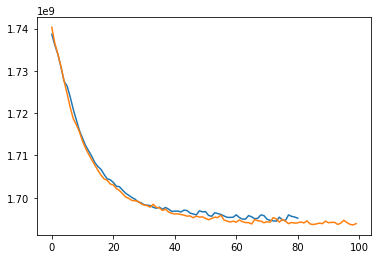

In [26]:
plt.plot(loss_sgdp_tri1)
plt.plot(loss_sgdp_tri2)

In [27]:
from simplecryoem.fsc import calc_fsc

In [59]:
res, fsc, shell_pts = calc_fsc(v_sgdp_tri1, v_sgdp_tri2, [1, nx])

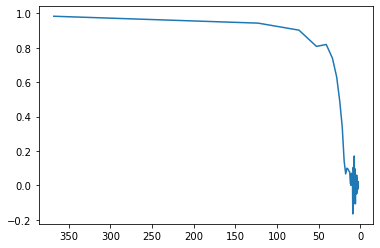

In [62]:
res_angs = nx * pixel_size[0] / res
plt.plot(res_angs[1:], fsc[1:])
plt.gca().invert_xaxis()

In [31]:
N_epochs = 20


In [32]:
key, key_alg = random.split(key)

v_sgdp_nn1, loss_sgdp_nn1, _, _ = precon_sgd(
    key_alg,
    loss_func_nn1,
    grad_func_nn1,
    hvp_func_nn1,
    v0,
    step_size,
    D0,
    beta,
    thresh,
    N_epochs,
    batch_size,
    N//2,
    c=c,
    adaptive_step_size=True,
    iter_display=1,
)

Epoch 1/20


100%|██████████| 10/10 [00:11<00:00,  1.16s/it, eta=9.675e-02, loss=1.692e+09]


  Loss =  1.72903857e+09
  eta = 0.09674588159999999
  alpha= 1e-06
Epoch 2/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.699e+09]


  Loss =  1.70972743e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 3/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.699e+09]


  Loss =  1.70290657e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 4/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.696e+09]


  Loss =  1.70079718e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 5/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.697e+09]


  Loss =  1.70008758e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 6/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.698e+09]


  Loss =  1.70004853e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 7/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.697e+09]


  Loss =  1.70003555e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 8/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.696e+09]


  Loss =  1.70001777e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 9/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.700e+09]


  Loss =  1.70047912e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 10/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.695e+09]


  Loss =  1.70015520e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 11/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.696e+09]


  Loss =  1.70051616e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 12/20


100%|██████████| 10/10 [00:12<00:00,  1.21s/it, eta=4.837e-02, loss=1.700e+09]


  Loss =  1.70037631e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 13/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.694e+09]


  Loss =  1.70009059e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 14/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.696e+09]


  Loss =  1.70049027e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 15/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.695e+09]


  Loss =  1.70015585e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 16/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.696e+09]


  Loss =  1.70055930e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 17/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.694e+09]


  Loss =  1.70019887e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 18/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.695e+09]


  Loss =  1.70056293e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 19/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.703e+09]


  Loss =  1.70057398e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 20/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.700e+09]


  Loss =  1.70065338e+09
  eta = 0.04837294079999999
  alpha= 1e-06


In [33]:
key, key_alg = random.split(key)

v_sgdp_nn2, loss_sgdp_nn2, _, _ = precon_sgd(
    key_alg,
    loss_func_nn2,
    grad_func_nn2,
    hvp_func_nn2,
    v0,
    step_size,
    D0,
    beta,
    thresh,
    N_epochs,
    batch_size,
    N//2,
    c=c,
    adaptive_step_size=True,
    iter_display=1,
)

Epoch 1/20


100%|██████████| 10/10 [00:11<00:00,  1.16s/it, eta=9.675e-02, loss=1.691e+09]


  Loss =  1.72816509e+09
  eta = 0.09674588159999999
  alpha= 1e-06
Epoch 2/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.703e+09]


  Loss =  1.70882651e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 3/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.698e+09]


  Loss =  1.70194982e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 4/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.698e+09]


  Loss =  1.69985815e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 5/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.697e+09]


  Loss =  1.69928793e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 6/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.694e+09]


  Loss =  1.69907357e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 7/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.698e+09]


  Loss =  1.69896324e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 8/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.697e+09]


  Loss =  1.69952109e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 9/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.700e+09]


  Loss =  1.69972682e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 10/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.695e+09]


  Loss =  1.69924892e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 11/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.694e+09]


  Loss =  1.69914535e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 12/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.699e+09]


  Loss =  1.69896425e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 13/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.694e+09]


  Loss =  1.69906891e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 14/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.695e+09]


  Loss =  1.69910070e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 15/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.698e+09]


  Loss =  1.69956889e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 16/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.691e+09]


  Loss =  1.69920241e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 17/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.695e+09]


  Loss =  1.69911546e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 18/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.695e+09]


  Loss =  1.69959250e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 19/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.698e+09]


  Loss =  1.69925306e+09
  eta = 0.04837294079999999
  alpha= 1e-06
Epoch 20/20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it, eta=4.837e-02, loss=1.696e+09]


  Loss =  1.69913542e+09
  eta = 0.04837294079999999
  alpha= 1e-06


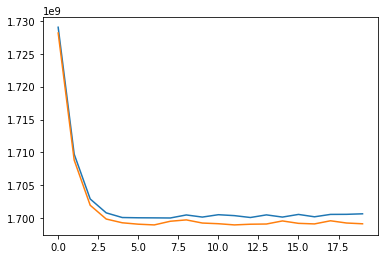

In [34]:
plt.plot(loss_sgdp_nn1)
plt.plot(loss_sgdp_nn2)


In [64]:
res_nn, fsc_nn, shell_pts = calc_fsc(v_sgdp_nn1, v_sgdp_nn2, [1, nx])

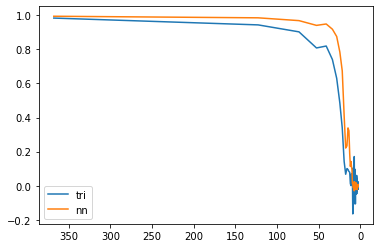

In [68]:
res_angs = nx * pixel_size[0] / res

plt.plot(res_angs, fsc)
plt.plot(res_angs, fsc_nn)
plt.legend(['tri', 'nn'])
plt.gca().invert_xaxis()

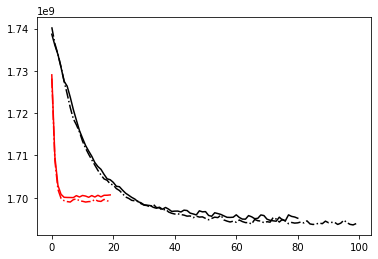

In [69]:
plt.plot(loss_sgdp_nn1, 'r-')
plt.plot(loss_sgdp_nn2, 'r-.')

plt.plot(loss_sgdp_tri1, 'k-')
plt.plot(loss_sgdp_tri2, 'k-.')



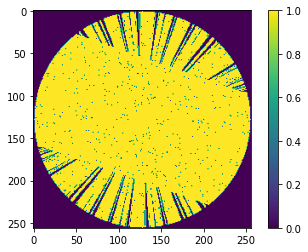

In [70]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_sgdp_nn1[0]))>1)
plt.colorbar()